In [2]:
# Install required packages (uncomment if running for the first time)
#!pip install torch torchvision timm opencv-python pillow segment-anything open_clip_torch matplotlib

import os
import torch
import torchvision.transforms as T
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


  Using cached matplotlib-3.10.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.57.0-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (102 kB)
  Using cached kiwisolver-1.4.8-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.2 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.6 MB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.57.0-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.9 MB)
Using cached kiwisolver-1.4.8-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.5 MB)
Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)


In [3]:
# Download PASCAL VOC 2012 (if not already downloaded)
!tar -xf VOCtrainval_11-May-2012.tar

# Set paths
VOC_ROOT = './VOCdevkit/VOC2012/'
IMG_DIR = os.path.join(VOC_ROOT, 'JPEGImages')
MASK_DIR = os.path.join(VOC_ROOT, 'SegmentationClass')
SPLIT_DIR = os.path.join(VOC_ROOT, 'ImageSets/Segmentation')


In [4]:
# A: One example image and mask (e.g., with a dog)
with open(os.path.join(SPLIT_DIR, 'train.txt')) as f:
    train_ids = f.read().splitlines()

# Find an image containing 'dog' (class 12 in VOC)
from collections import Counter

def has_dog(mask_path):
    mask = np.array(Image.open(mask_path))
    return 12 in np.unique(mask)

item_a_id = None
for img_id in train_ids:
    mask_path = os.path.join(MASK_DIR, img_id + '.png')
    if has_dog(mask_path):
        item_a_id = img_id
        break

item_a_img = os.path.join(IMG_DIR, item_a_id + '.jpg')
item_a_mask = os.path.join(MASK_DIR, item_a_id + '.png')

# B: Textual description
item_b_text = "A dog is a four-legged domestic animal commonly kept as a pet."

# C: Unlabeled images (take 100 random train images, remove masks)
import random
item_c_ids = random.sample([i for i in train_ids if i != item_a_id], 100)
item_c_imgs = [os.path.join(IMG_DIR, img_id + '.jpg') for img_id in item_c_ids]

# D: Test set (VOC val set)
with open(os.path.join(SPLIT_DIR, 'val.txt')) as f:
    val_ids = f.read().splitlines()
item_d_imgs = [os.path.join(IMG_DIR, img_id + '.jpg') for img_id in val_ids]
item_d_masks = [os.path.join(MASK_DIR, img_id + '.png') for img_id in val_ids]


In [5]:
import open_clip

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
clip_model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
clip_model = clip_model.to(device)
tokenizer = open_clip.get_tokenizer('ViT-B-32')

def clip_predict(img_path, text):
    image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
    text = tokenizer([text]).to(device)
    with torch.no_grad():
        image_features = clip_model.encode_image(image)
        text_features = clip_model.encode_text(text)
        logits_per_image = (image_features @ text_features.T).squeeze()
    return logits_per_image.item()

# Filter C for likely "dog" images
clip_scores = [clip_predict(img, item_b_text) for img in item_c_imgs]
threshold = np.percentile(clip_scores, 80)  # Top 20% as likely
likely_dog_imgs = [img for img, score in zip(item_c_imgs, clip_scores) if score >= threshold]

print(f"Selected {len(likely_dog_imgs)} pseudo-labeled images.")


open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Selected 20 pseudo-labeled images.


In [10]:
#!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

wget: WGETRC points to /Users/kash/.config/wgetrc, which couldn't be accessed because of error: No such file or directory.


In [6]:
# You need the Segment Anything Model (SAM) weights and code.
# Instructions: https://github.com/facebookresearch/segment-anything

from segment_anything import sam_model_registry, SamPredictor
sam_checkpoint = "sam_vit_b_01ec64.pth"  # Download from SAM repo
sam = sam_model_registry["vit_b"](checkpoint=sam_checkpoint)
sam = sam.to(device)
predictor = SamPredictor(sam)

def sam_generate_mask(img_path, prompt_point=None):
    image = np.array(Image.open(img_path))
    predictor.set_image(image)
    if prompt_point is None:
        # Use center of image as a weak prior
        h, w = image.shape[:2]
        prompt_point = np.array([[w//2, h//2]])
        prompt_label = np.array([1])
    else:
        prompt_label = np.array([1])
    masks, scores, _ = predictor.predict(
        point_coords=prompt_point,
        point_labels=prompt_label,
        multimask_output=True,
    )
    best_mask = masks[np.argmax(scores)]
    return best_mask

# Generate pseudo-labels for likely dog images
os.makedirs('pseudo_labels', exist_ok=True)
for img_path in likely_dog_imgs:
    mask = sam_generate_mask(img_path)
    mask_img = Image.fromarray((mask * 255).astype(np.uint8))
    mask_img.save('pseudo_labels/' + os.path.basename(img_path).replace('.jpg', '_mask.png'))


In [7]:
# Install dependencies if not already installed
!pip install torch torchvision transformers datasets pillow tqdm

import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
from tqdm import tqdm


  Using cached tokenizers-0.21.1-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.8 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 MB 70.8 MB/s eta 0:00:00a 0:00:01
Using cached tokenizers-0.21.1-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.0 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 74.5 MB/s eta 0:00:00
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2


In [11]:
class PseudoLabeledDataset(Dataset):
    def __init__(self, image_paths, mask_paths, processor):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.processor = processor

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx])
        # Convert mask to single channel (0: background, 1: dog)
        mask = mask.point(lambda p: 1 if p > 127 else 0)
        # Processor will resize and normalize
        inputs = self.processor(images=image, segmentation_maps=mask, return_tensors="pt")
        inputs = {k: v.squeeze() for k, v in inputs.items()}
        return inputs


In [12]:
# Assume you have:
# likely_dog_imgs: list of image paths
# pseudo_label_paths: list of mask paths (same order as images)

processor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

# Example: mask paths are in 'pseudo_labels' folder
pseudo_label_paths = [os.path.join('pseudo_labels', os.path.basename(img).replace('.jpg', '_mask.png')) for img in likely_dog_imgs]

dataset = PseudoLabeledDataset(likely_dog_imgs, pseudo_label_paths, processor)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

/home/scai/mtech/aib242289/.conda/envs/cv/lib/python3.12/site-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


In [13]:
model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    num_labels=2,  # Background & dog
    ignore_mismatched_sizes=True
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  

In [14]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

model.train()
for epoch in range(20):  # Adjust epochs as needed
    loop = tqdm(dataloader, desc=f"Epoch {epoch+1}")
    for batch in loop:
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].long().to(device)
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_postfix(loss=loss.item())


Epoch 20: 100%|██████████████████████| 5/5 [00:00<00:00,  6.40it/s, loss=0.0528]


In [16]:
model.save_pretrained("finetuned_segformer_dog")
processor.save_pretrained("finetuned_segformer_dog")

['finetuned_segformer_dog/preprocessor_config.json']

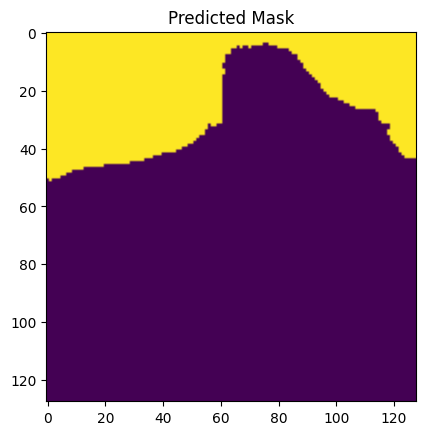

In [17]:
model.eval()
with torch.no_grad():
    for batch in dataloader:
        pixel_values = batch["pixel_values"].to(device)
        outputs = model(pixel_values=pixel_values)
        preds = outputs.logits.argmax(dim=1)
        break

# Visualize prediction
import matplotlib.pyplot as plt
plt.imshow(preds[0].cpu().numpy())
plt.title("Predicted Mask")
plt.show()


In [18]:
print(np.unique(preds[0].cpu().numpy()))

[0 1]


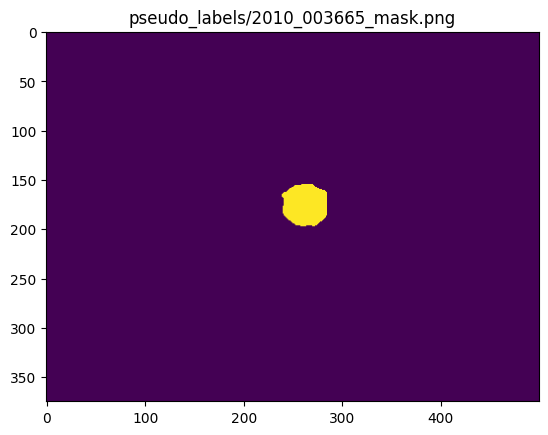

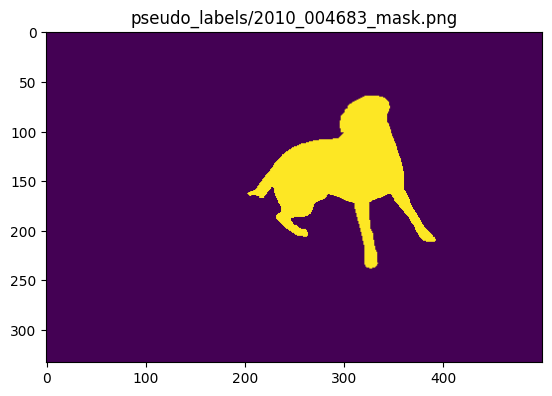

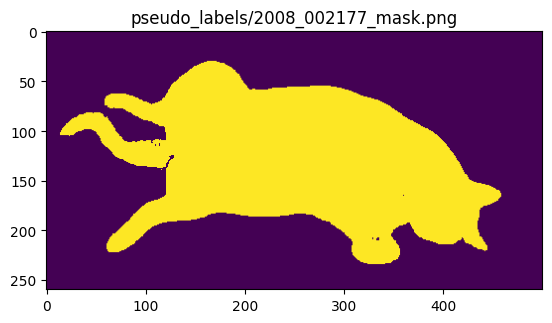

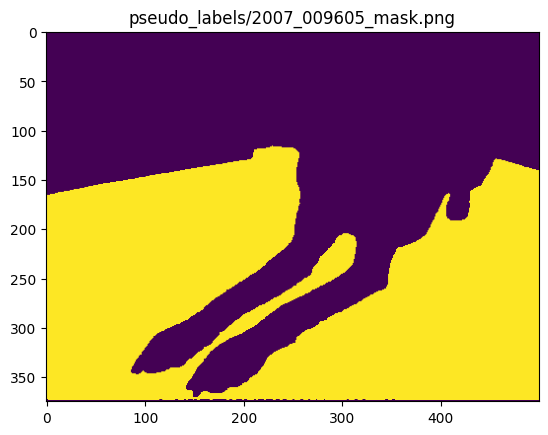

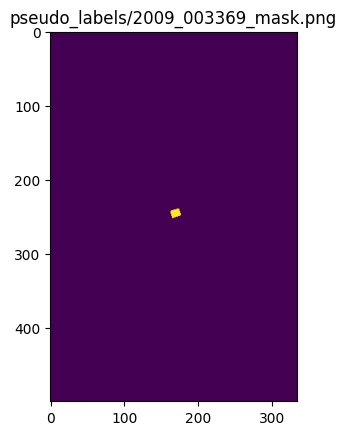

In [19]:
from PIL import Image
import matplotlib.pyplot as plt

for mask_path in pseudo_label_paths[:5]:
    mask = Image.open(mask_path)
    plt.imshow(mask)
    plt.title(mask_path)
    plt.show()


In [25]:
import torch
import numpy as np
from PIL import Image

def compute_iou(pred_mask, true_mask, num_classes=2):
    ious = []
    for cls in range(num_classes):
        pred_inds = (pred_mask == cls)
        true_inds = (true_mask == cls)
        intersection = (pred_inds & true_inds).sum().item()
        union = (pred_inds | true_inds).sum().item()
        if union == 0:
            ious.append(float('nan'))  # Ignore this class
        else:
            ious.append(intersection / union)
    return ious

def pixel_accuracy(pred_mask, true_mask):
    correct = (pred_mask == true_mask).sum().item()
    total = true_mask.numel()
    return correct / total

def evaluate(model, img_list, mask_list, processor, device):
    model.eval()
    iou_list = []
    pixel_acc_list = []

    with torch.no_grad():
        for img_path, mask_path in zip(img_list, mask_list):
            image = Image.open(img_path).convert("RGB")
            true_mask = Image.open(mask_path)
            # Convert true mask to binary (0 or 1) for the target class
            true_mask = true_mask.point(lambda p: 1 if p > 127 else 0)
            # Convert PIL Image to tensor with dtype torch.int64
            true_mask_tensor = torch.tensor(np.array(true_mask), dtype=torch.int64)
            # Prepare model input
            inputs = processor(images=image, return_tensors="pt")
            pixel_values = inputs.pixel_values.to(device)
            outputs = model(pixel_values=pixel_values)
            logits = outputs.logits
            pred_mask = torch.argmax(logits.squeeze(), dim=0).cpu()

            # Resize true mask to match prediction if needed
            if true_mask_tensor.shape != pred_mask.shape:
                from torchvision.transforms import functional as F
                true_mask_pil = Image.fromarray(true_mask_tensor.numpy().astype(np.uint8))
                true_mask_resized = F.resize(true_mask_pil, pred_mask.shape, interpolation=Image.NEAREST)
                true_mask_tensor = torch.tensor(np.array(true_mask_resized), dtype=torch.int64)

            # Compute metrics
            ious = compute_iou(pred_mask, true_mask_tensor, num_classes=2)
            iou_list.append(ious)
            pixel_acc = pixel_accuracy(pred_mask, true_mask_tensor)
            pixel_acc_list.append(pixel_acc)

    # Compute mean IoU ignoring NaNs
    iou_array = np.array(iou_list)
    mean_iou_per_class = np.nanmean(iou_array, axis=0)
    mean_iou = np.nanmean(mean_iou_per_class)
    mean_pixel_acc = np.mean(pixel_acc_list)

    return {"miou": mean_iou, "miou_per_class": mean_iou_per_class.tolist(), "pixel_acc": mean_pixel_acc}



In [26]:
metrics = evaluate(model, item_d_imgs, item_d_masks, processor, device)
print("mIoU:", metrics['miou'], "Pixel Accuracy:", metrics['pixel_acc'])

mIoU: 0.29510257240329024 Pixel Accuracy: 0.5779024680949146


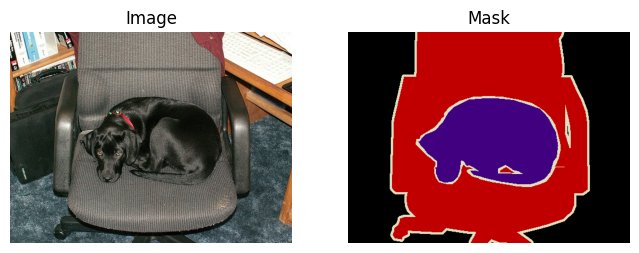

In [27]:
def show_img_and_mask(img_path, mask_path):
    img = Image.open(img_path)
    mask = Image.open(mask_path)
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); plt.imshow(img); plt.title('Image'); plt.axis('off')
    plt.subplot(1,2,2); plt.imshow(mask); plt.title('Mask'); plt.axis('off')
    plt.show()

show_img_and_mask(item_a_img, item_a_mask)